In [1]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
import jax
import seaborn as sns
import scipy.stats as stats

numpyro.set_host_device_count(4)
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [2]:
df = pd.read_csv('rugged.csv', sep=';')
df.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
0,ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,...,0,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN
1,AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,...,0,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.0
3,AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,...,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.0


In [3]:
df['log_gdp'] = np.log(df['rgdppc_2000'])
df = df[~df['log_gdp'].isna()]
df['log_gdp_std'] = df['log_gdp'] / df['log_gdp'].mean()
df['rugged_std'] = df['rugged'] / df['rugged'].max()
df['cid'] = (df['cont_africa'] == 1).astype(int)
df = df[['log_gdp', 'log_gdp_std', 'rugged_std', 'cid']]

In [4]:
df

,log_gdp,log_gdp_std,rugged_std,cid
2,7.492609,0.879712,0.138342,1
4,8.216929,0.964755,0.552564,0
7,9.933263,1.166270,0.123992,0
8,9.407032,1.104485,0.124960,0
9,7.792343,0.914904,0.433409,0
...,...,...,...,...
229,8.488849,0.996681,0.270397,0
230,6.669180,0.783032,0.374557,0
231,9.150497,1.074365,0.283941,1
232,6.651585,0.780967,0.085940,1


In [5]:
def model(rugged_std, cid, log_gdp_std=None):
    with numpyro.plate('cid', len(np.unique(cid))):
        α = numpyro.sample(
            'α',
            dist.Normal(loc=1, scale=.1),
        )
        β = numpyro.sample(
            'β',
            dist.Normal(loc=0, scale=.3),
        )
    σ = numpyro.sample(
        'σ',
        dist.Exponential(rate=1),
    )
    
    μ = numpyro.deterministic(
        'μ',
        α[cid] + β[cid]*(rugged_std - .215),
    )
    
    numpyro.sample(
        'obs',
        dist.Normal(μ, σ),
        obs=log_gdp_std,
    )

In [6]:
prior_predictive = Predictive(model, num_samples=100)
prior_samples = prior_predictive(
    random.PRNGKey(1),
    rugged_std=df['rugged_std'].to_numpy(),
    cid=df['cid'].to_numpy(),
)

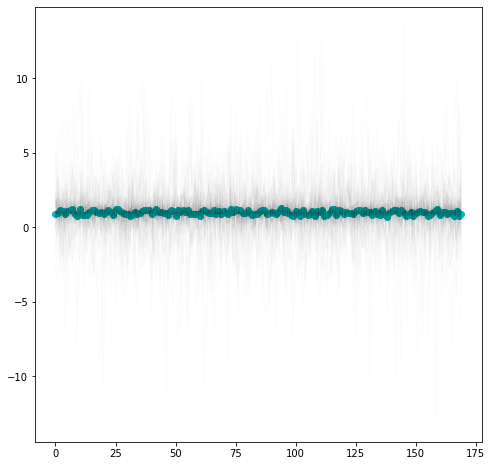

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.arange(len(df)), df['log_gdp_std'].to_numpy(), 'co');
ax.plot(np.arange(len(df)), prior_samples['obs'].T, c='k', alpha=.01);

In [8]:
sampler = NUTS(model)
mcmc = MCMC(
    sampler=sampler,
    num_warmup=500,
    num_samples=500,
    num_chains=4,
)
mcmc.run(
    random.PRNGKey(2),
    rugged_std=df['rugged_std'].to_numpy(),
    cid=df['cid'].to_numpy(),
    log_gdp_std=df['log_gdp_std'].to_numpy(),
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
samples = mcmc.get_samples()

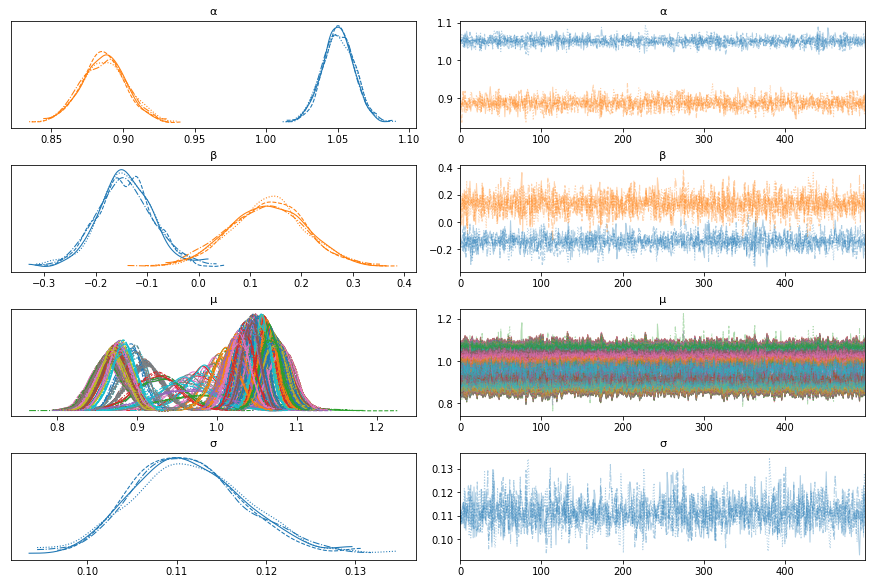

In [10]:
az.plot_trace(az.from_numpyro(mcmc));

In [11]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      α[0]      1.05      0.01      1.05      1.03      1.07   2697.97      1.00
      α[1]      0.89      0.02      0.89      0.86      0.91   2336.05      1.00
      β[0]     -0.14      0.05     -0.14     -0.23     -0.06   2321.13      1.00
      β[1]      0.13      0.07      0.14      0.01      0.26   2583.15      1.00
         σ      0.11      0.01      0.11      0.10      0.12   2244.54      1.00

Number of divergences: 0


## 9M1

In [12]:
def model(rugged_std, cid, log_gdp_std=None):
    with numpyro.plate('cid', len(np.unique(cid))):
        α = numpyro.sample(
            'α',
            dist.Normal(loc=1, scale=.1),
        )
        β = numpyro.sample(
            'β',
            dist.Normal(loc=0, scale=.3),
        )
    σ = numpyro.sample(
        'σ',
        dist.Uniform(low=0, high=1),
    )
    
    μ = numpyro.deterministic(
        'μ',
        α[cid] + β[cid]*(rugged_std - .215),
    )
    
    numpyro.sample(
        'obs',
        dist.Normal(μ, σ),
        obs=log_gdp_std,
    )

In [13]:
prior_predictive = Predictive(model, num_samples=100)
prior_samples = prior_predictive(
    random.PRNGKey(1),
    rugged_std=df['rugged_std'].to_numpy(),
    cid=df['cid'].to_numpy(),
)

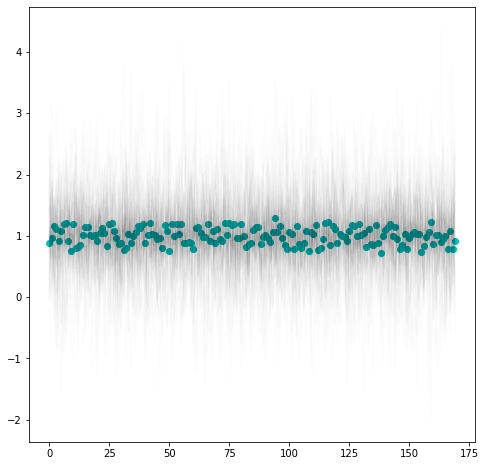

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.arange(len(df)), df['log_gdp_std'].to_numpy(), 'co');
ax.plot(np.arange(len(df)), prior_samples['obs'].T, c='k', alpha=.01);

In [15]:
sampler = NUTS(model)
mcmc = MCMC(
    sampler=sampler,
    num_warmup=500,
    num_samples=500,
    num_chains=4,
)
mcmc.run(
    random.PRNGKey(2),
    rugged_std=df['rugged_std'].to_numpy(),
    cid=df['cid'].to_numpy(),
    log_gdp_std=df['log_gdp_std'].to_numpy(),
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
samples = mcmc.get_samples()

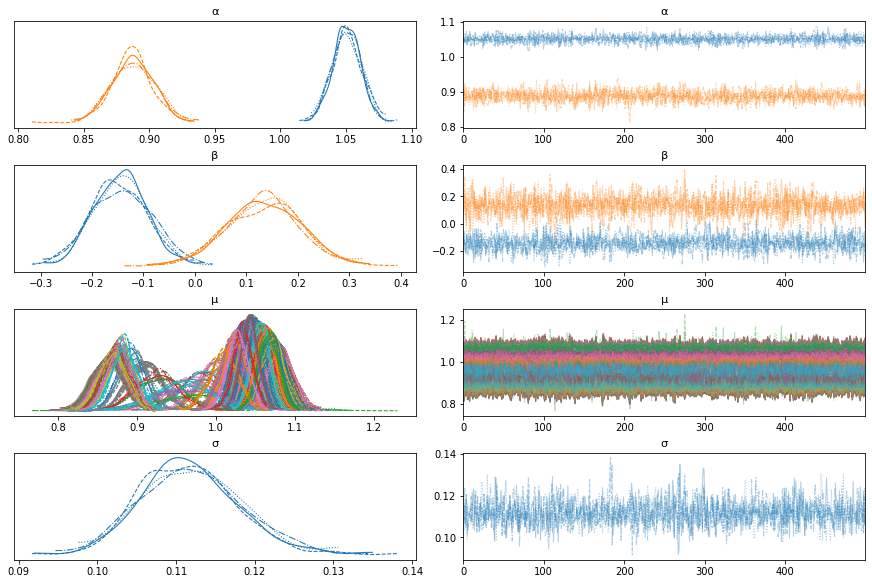

In [17]:
az.plot_trace(az.from_numpyro(mcmc));

In [18]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      α[0]      1.05      0.01      1.05      1.03      1.07   2925.92      1.00
      α[1]      0.89      0.02      0.89      0.86      0.91   2072.16      1.00
      β[0]     -0.14      0.06     -0.14     -0.23     -0.05   2198.26      1.00
      β[1]      0.13      0.07      0.14      0.01      0.25   2263.23      1.00
         σ      0.11      0.01      0.11      0.10      0.12   2072.66      1.00

Number of divergences: 0


## 9M2

In [19]:
def model(rugged_std, cid, log_gdp_std=None):
    with numpyro.plate('cid', len(np.unique(cid))):
        α = numpyro.sample(
            'α',
            dist.Normal(loc=1, scale=.1),
        )
        β = numpyro.sample(
            'β',
            dist.Exponential(rate=.3),
        )
    σ = numpyro.sample(
        'σ',
        dist.Exponential(rate=1),
    )
    
    μ = numpyro.deterministic(
        'μ',
        α[cid] + β[cid]*(rugged_std - .215),
    )
    
    numpyro.sample(
        'obs',
        dist.Normal(μ, σ),
        obs=log_gdp_std,
    )

In [20]:
prior_predictive = Predictive(model, num_samples=100)
prior_samples = prior_predictive(
    random.PRNGKey(1),
    rugged_std=df['rugged_std'].to_numpy(),
    cid=df['cid'].to_numpy(),
)

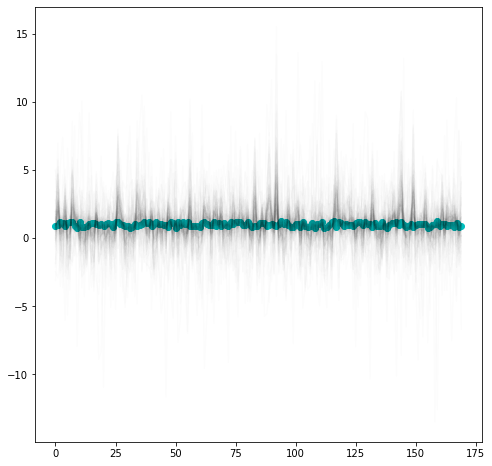

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.arange(len(df)), df['log_gdp_std'].to_numpy(), 'co');
ax.plot(np.arange(len(df)), prior_samples['obs'].T, c='k', alpha=.01);

In [22]:
sampler = NUTS(model)
mcmc = MCMC(
    sampler=sampler,
    num_warmup=500,
    num_samples=500,
    num_chains=4,
)
mcmc.run(
    random.PRNGKey(2),
    rugged_std=df['rugged_std'].to_numpy(),
    cid=df['cid'].to_numpy(),
    log_gdp_std=df['log_gdp_std'].to_numpy(),
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
samples = mcmc.get_samples()

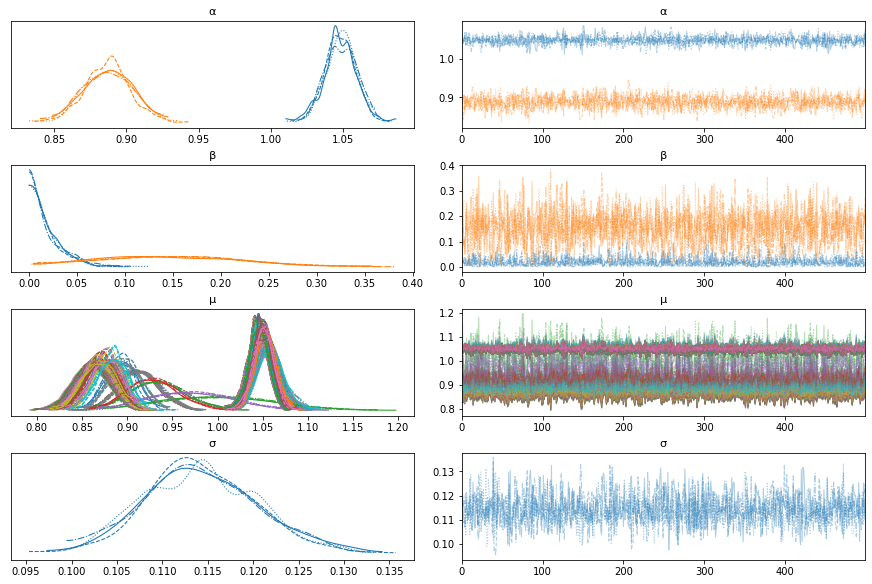

In [24]:
az.plot_trace(az.from_numpyro(mcmc));

In [25]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      α[0]      1.05      0.01      1.05      1.03      1.07   2084.52      1.00
      α[1]      0.89      0.02      0.89      0.86      0.92   1598.34      1.00
      β[0]      0.02      0.02      0.01      0.00      0.04   2286.59      1.00
      β[1]      0.15      0.07      0.14      0.03      0.26   1434.77      1.00
         σ      0.11      0.01      0.11      0.10      0.12   2011.11      1.00

Number of divergences: 0


## 9M3

In [26]:
def model(rugged_std, cid, log_gdp_std=None):
    with numpyro.plate('cid', len(np.unique(cid))):
        α = numpyro.sample(
            'α',
            dist.Normal(loc=1, scale=.1),
        )
        β = numpyro.sample(
            'β',
            dist.Normal(loc=0, scale=.3),
        )
    σ = numpyro.sample(
        'σ',
        dist.Exponential(rate=1),
    )
    
    μ = numpyro.deterministic(
        'μ',
        α[cid] + β[cid]*(rugged_std - .215),
    )
    
    numpyro.sample(
        'obs',
        dist.Normal(μ, σ),
        obs=log_gdp_std,
    )

In [27]:
sampler = NUTS(model)
mcmc = MCMC(
    sampler=sampler,
    num_warmup=10,
    num_samples=500,
    num_chains=4,
)
mcmc.run(
    random.PRNGKey(2),
    rugged_std=df['rugged_std'].to_numpy(),
    cid=df['cid'].to_numpy(),
    log_gdp_std=df['log_gdp_std'].to_numpy(),
)

  0%|          | 0/510 [00:00<?, ?it/s]

  0%|          | 0/510 [00:00<?, ?it/s]

  0%|          | 0/510 [00:00<?, ?it/s]

  0%|          | 0/510 [00:00<?, ?it/s]

In [28]:
samples = mcmc.get_samples()

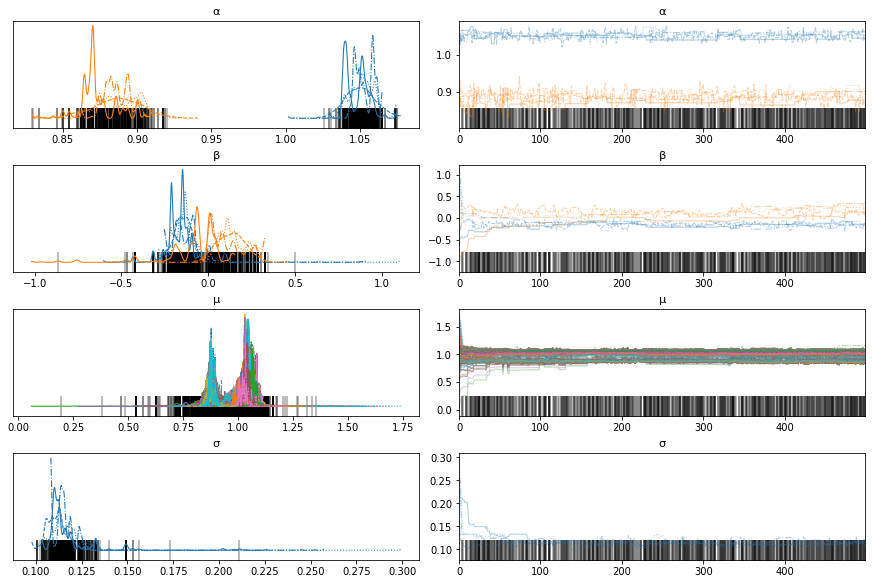

In [29]:
az.plot_trace(az.from_numpyro(mcmc));

In [30]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      α[0]      1.05      0.01      1.05      1.04      1.06    127.79      1.06
      α[1]      0.88      0.02      0.88      0.86      0.91     17.83      1.12
      β[0]     -0.14      0.09     -0.15     -0.26     -0.06     32.88      1.14
      β[1]      0.08      0.15      0.08     -0.10      0.29      5.98      1.58
         σ      0.12      0.01      0.11      0.10      0.13     36.50      1.10

Number of divergences: 736


In [31]:
sampler = NUTS(model)
mcmc = MCMC(
    sampler=sampler,
    num_warmup=100,
    num_samples=500,
    num_chains=4,
)
mcmc.run(
    random.PRNGKey(2),
    rugged_std=df['rugged_std'].to_numpy(),
    cid=df['cid'].to_numpy(),
    log_gdp_std=df['log_gdp_std'].to_numpy(),
)

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [32]:
samples = mcmc.get_samples()

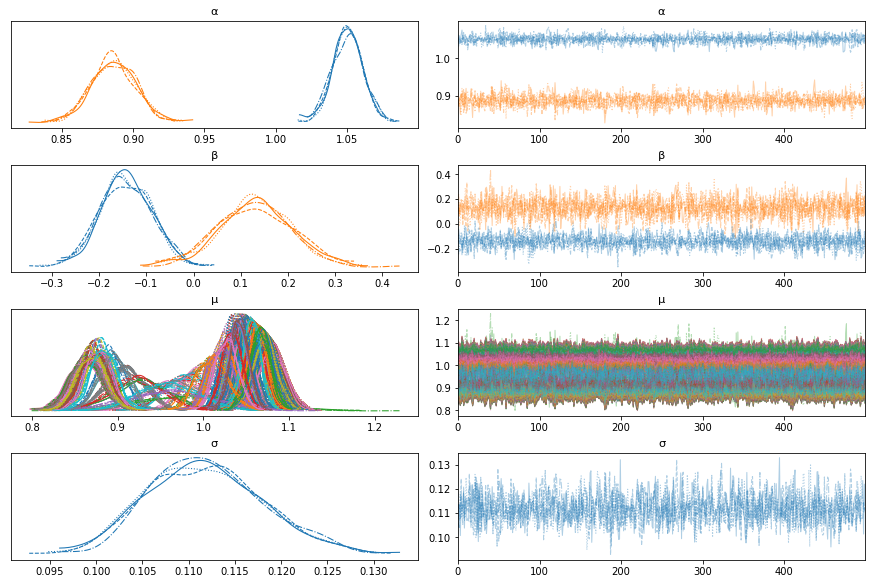

In [33]:
az.plot_trace(az.from_numpyro(mcmc));

In [34]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      α[0]      1.05      0.01      1.05      1.03      1.07   2497.51      1.00
      α[1]      0.89      0.02      0.89      0.86      0.91   1975.15      1.00
      β[0]     -0.14      0.05     -0.14     -0.23     -0.05   2333.17      1.00
      β[1]      0.13      0.08      0.13      0.00      0.26   2243.70      1.00
         σ      0.11      0.01      0.11      0.10      0.12   2351.80      1.00

Number of divergences: 0


## 9H1

In [35]:
def model(a=None, b=None, y=None):
    a = numpyro.sample(
        'a',
        dist.Normal(loc=0, scale=1),
    )
    b = numpyro.sample(
        'b',
        dist.Cauchy(loc=0, scale=1),
    )

sampler = NUTS(model)
mcmc = MCMC(sampler, num_warmup=500, num_samples=500, num_chains=1)
mcmc.run(random.PRNGKey(1), y=jnp.array([1]))

sample: 100%|██████████| 1000/1000 [00:01<00:00, 646.99it/s, 3 steps of size 4.61e-01. acc. prob=0.74]


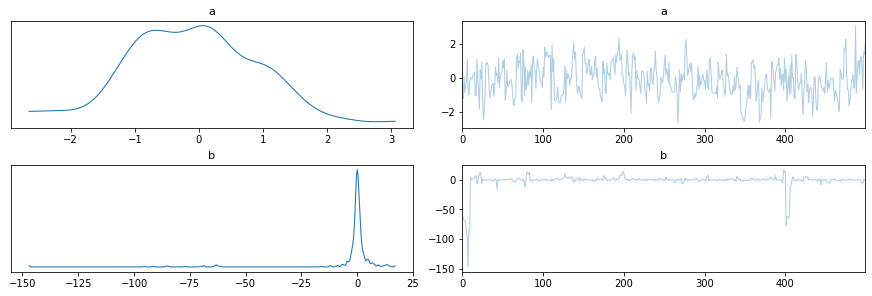

In [36]:
az.plot_trace(az.from_numpyro(mcmc));

In [37]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.12      0.96     -0.10     -1.48      1.46    127.89      1.03
         b     -1.92     14.23      0.10     -5.01      6.28     65.16      1.00

Number of divergences: 0


## 9H2

In [4]:
df = pd.read_csv('divorce.csv', sep=';')

In [5]:
df

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000


In [7]:
def standardize(x):
    return (x - np.mean(x))/np.std(x)

d = standardize(df['Divorce'].to_numpy())
m = standardize(df['Marriage'].to_numpy())
a = standardize(df['MedianAgeMarriage'].to_numpy())

In [22]:
def m51(age, divorce):
    α  = numpyro.sample(
        'α',
        dist.Normal(0, 0.2),
    )
    β_age  = numpyro.sample(
        'β_age',
        dist.Normal(0, 0.5),
    )
    σ  = numpyro.sample(
        'σ',
        dist.Exponential(rate=1),
    )
    
    μ = numpyro.deterministic(
        'μ',
        α + β_age*age,
    )
    
    numpyro.sample(
        'obs',
        dist.Normal(μ, σ),
        obs=divorce,
    )

In [23]:
sampler = NUTS(m51)
mcmc = MCMC(sampler, num_warmup=500, num_samples=500)
mcmc.run(random.PRNGKey(1), age=a, divorce=d)

sample: 100%|██████████| 1000/1000 [00:02<00:00, 458.48it/s, 7 steps of size 7.36e-01. acc. prob=0.94]


In [24]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         α     -0.00      0.10     -0.01     -0.17      0.14    428.76      1.00
     β_age     -0.57      0.11     -0.57     -0.75     -0.40    502.75      1.00
         σ      0.83      0.08      0.83      0.71      0.96    504.13      1.00

Number of divergences: 0


In [25]:
az.waic(az.from_numpyro(mcmc))

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 500 by 50 log-likelihood matrix

          Estimate       SE
elpd_waic   -63.04     6.21
p_waic        3.24        -

There has been a warning during the calculation. Please check the results.

In [26]:
def m52(marriage, divorce):
    α  = numpyro.sample(
        'α',
        dist.Normal(0, 0.2),
    )
    β_marriage  = numpyro.sample(
        'β_marriage',
        dist.Normal(0, 0.5),
    )
    σ  = numpyro.sample(
        'σ',
        dist.Exponential(rate=1),
    )
    
    μ = numpyro.deterministic(
        'μ',
        α + β_marriage*marriage,
    )
    
    numpyro.sample(
        'obs',
        dist.Normal(μ, σ),
        obs=divorce,
    )

In [27]:
sampler = NUTS(m52)
mcmc = MCMC(sampler, num_warmup=500, num_samples=500)
mcmc.run(random.PRNGKey(1), marriage=m, divorce=d)

sample: 100%|██████████| 1000/1000 [00:02<00:00, 493.99it/s, 3 steps of size 8.27e-01. acc. prob=0.91]


In [28]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
           α     -0.00      0.12     -0.00     -0.20      0.20    527.69      1.00
  β_marriage      0.34      0.12      0.34      0.15      0.53    548.26      1.00
           σ      0.95      0.10      0.95      0.80      1.10    335.27      1.00

Number of divergences: 0


In [29]:
az.waic(az.from_numpyro(mcmc))

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 500 by 50 log-likelihood matrix

          Estimate       SE
elpd_waic   -70.04     4.90
p_waic        2.83        -

There has been a warning during the calculation. Please check the results.

In [30]:
def m53(age, marriage, divorce):
    α  = numpyro.sample(
        'α',
        dist.Normal(0, 0.2),
    )
    β_age  = numpyro.sample(
        'β_age',
        dist.Normal(0, 0.5),
    )
    β_marriage  = numpyro.sample(
        'β_marriage',
        dist.Normal(0, 0.5),
    )
    σ  = numpyro.sample(
        'σ',
        dist.Exponential(rate=1),
    )
    
    μ = numpyro.deterministic(
        'μ',
        α + β_marriage*marriage + β_age*age,
    )
    
    numpyro.sample(
        'obs',
        dist.Normal(μ, σ),
        obs=divorce,
    )

In [31]:
sampler = NUTS(m53)
mcmc = MCMC(sampler, num_warmup=500, num_samples=500)
mcmc.run(random.PRNGKey(1), age=a, marriage=m, divorce=d)

sample: 100%|██████████| 1000/1000 [00:02<00:00, 427.62it/s, 3 steps of size 5.25e-01. acc. prob=0.93]


In [32]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
           α      0.00      0.10      0.00     -0.15      0.16    422.20      1.00
       β_age     -0.60      0.15     -0.60     -0.87     -0.37    358.55      1.00
  β_marriage     -0.05      0.15     -0.05     -0.31      0.18    352.48      1.00
           σ      0.83      0.09      0.83      0.70      0.97    360.20      1.00

Number of divergences: 0


In [33]:
az.waic(az.from_numpyro(mcmc))

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 500 by 50 log-likelihood matrix

          Estimate       SE
elpd_waic   -64.33     6.50
p_waic        4.81        -

There has been a warning during the calculation. Please check the results.

## 9H3, 9H4

In [2]:
import scipy.stats as stats
n = 100
height = stats.norm(loc=10, scale=2).rvs(size=n)
leg_prop = stats.uniform(loc=0, scale=1).rvs(size=n)
leg_left = leg_prop*height + stats.norm(loc=0, scale=.02).rvs(size=n)
leg_right = leg_prop*height + stats.norm(loc=0, scale=.02).rvs(size=n)

In [11]:
def m58(left, right, height):
    α = numpyro.sample(
        'α',
        dist.Normal(10, 100),
    )
    β_left = numpyro.sample(
        'β_left',
        dist.Normal(2, 10),
    )
    β_right = numpyro.sample(
        'β_right',
        dist.Normal(2, 10),
    )
    σ = numpyro.sample(
        'σ',
        dist.Exponential(rate=1),
    )
    μ = α + β_left*left + β_right*right
    
    numpyro.sample(
        'obs',
        dist.Normal(μ, σ),
        obs=height,
    )

In [12]:
sampler = NUTS(m58)
mcmc = MCMC(sampler, num_warmup=500, num_samples=500)
mcmc.run(random.PRNGKey(1), left=leg_left, right=leg_right, height=height)

sample: 100%|██████████| 1000/1000 [00:02<00:00, 373.79it/s, 1023 steps of size 4.07e-03. acc. prob=0.95]


In [13]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         α      8.82      0.38      8.81      8.21      9.42    287.01      1.00
    β_left     -0.20      4.94     -0.50     -7.25      8.67    200.70      1.00
   β_right      0.43      4.95      0.75     -8.42      7.52    200.90      1.00
         σ      2.00      0.15      2.00      1.76      2.26    199.14      1.00

Number of divergences: 0


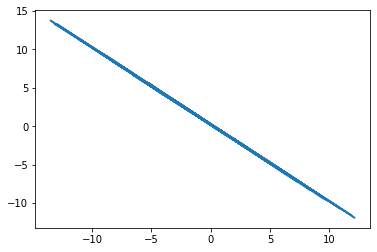

In [14]:
fig, ax = plt.subplots()
samples = mcmc.get_samples()
ax.plot(samples['β_left'], samples['β_right'])

In [56]:
az.waic(az.from_numpyro(mcmc))

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 500 by 100 log-likelihood matrix

          Estimate       SE
elpd_waic  -222.67     8.12
p_waic        3.66        -

There has been a warning during the calculation. Please check the results.

In [46]:
def m58_s2(left, right, height):
    α = numpyro.sample(
        'α',
        dist.Normal(10, 10),
    )
    β_left = numpyro.sample(
        'β_left',
        dist.TruncatedNormal(low=0, loc=2, scale=1),
    )
    β_right = numpyro.sample(
        'β_right',
        dist.TruncatedNormal(low=0, loc=2, scale=1),
    )
    σ = numpyro.sample(
        'σ',
        dist.Exponential(rate=1),
    )
    μ = α - β_left*left + β_right*right
    
    numpyro.sample(
        'obs',
        dist.Normal(μ, σ),
        obs=height,
    )

In [47]:
prior_pred = Predictive(m58_s2, num_samples=100)
prior_samples = prior_pred(random.PRNGKey(1), left=leg_left, right=leg_right, height=None)

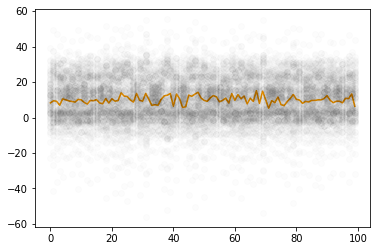

In [48]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(height)), height, c='orange')
ax.plot(np.arange(len(height)), prior_samples['obs'].T, 'ko', alpha=.01);

In [49]:
sampler = NUTS(m58_s2)
mcmc = MCMC(sampler, num_warmup=500, num_samples=500)
mcmc.run(random.PRNGKey(1), left=leg_left, right=leg_right, height=height, )

sample: 100%|██████████| 1000/1000 [00:02<00:00, 396.45it/s, 127 steps of size 2.28e-02. acc. prob=0.92]


In [50]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         α      8.85      0.36      8.86      8.24      9.40    278.85      1.01
    β_left      2.02      0.70      1.98      0.95      3.26    175.96      1.00
   β_right      2.25      0.69      2.22      1.11      3.41    174.56      1.00
         σ      1.99      0.15      2.00      1.74      2.20    277.63      1.00

Number of divergences: 0


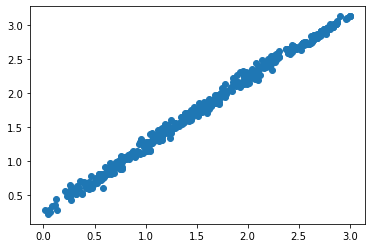

In [19]:
fig, ax = plt.subplots()
samples = mcmc.get_samples()
ax.plot(samples['β_left'], samples['β_right'], 'o')

In [9]:
samples

{'α': DeviceArray([ 9.009004 ,  8.714013 ,  8.715421 ,  9.229356 ,  9.125779 ,
               9.024788 ,  9.506598 ,  9.294372 ,  8.73748  ,  8.640002 ,
               9.486559 ,  9.53758  ,  9.558621 ,  9.446471 ,  8.813485 ,
               8.642731 ,  8.524612 ,  8.611135 ,  8.662707 ,  8.798444 ,
               9.089334 ,  9.073246 ,  9.168318 ,  9.159287 ,  9.441394 ,
               9.870055 ,  9.687704 ,  8.897597 ,  9.236174 ,  9.32694  ,
               9.877415 ,  8.080161 ,  8.026998 ,  9.038716 ,  9.007877 ,
               9.01986  ,  8.573443 ,  9.185222 ,  9.231614 ,  8.803819 ,
               8.500002 ,  8.537605 ,  8.720872 ,  9.174979 ,  9.163316 ,
               9.163765 ,  8.833377 ,  8.947149 ,  8.902323 ,  8.912783 ,
               8.820197 ,  9.142928 ,  8.582972 ,  8.330301 ,  8.877417 ,
               8.993644 ,  8.593274 ,  8.775025 ,  8.9855   ,  8.891486 ,
               8.909561 ,  8.909561 ,  8.748174 ,  8.95932  ,  8.634013 ,
               8.990772 ,  8.9805

In [61]:
az.waic(az.from_numpyro(mcmc))

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 500 by 100 log-likelihood matrix

          Estimate       SE
elpd_waic  -222.88     8.23
p_waic        3.56        -

There has been a warning during the calculation. Please check the results.

## 9H5

In [83]:
from tqdm import tqdm
num_weeks = 1_000
positions = np.zeros(num_weeks)
current = 10
for i in tqdm(range(num_weeks)):
    positions[i] = current
    proposal = current + np.random.choice(np.array([-1, 1]), size=1)
    if proposal < 1:
        proposal = 10
    if proposal > 10:
        proposal = 1
    prob_move = proposal / current
    if stats.uniform(loc=0, scale=1).rvs(size=1) < prob_move:
        current = proposal
    else:
        current = current

100%|██████████| 1000/1000 [00:00<00:00, 1697.28it/s]


In [84]:
df = pd.DataFrame({'val': positions}).value_counts(normalize=True).to_frame(name='val')
df['expected'] = (np.arange(1, 11) / 55)[::-1]
df

,val,expected
val,,
10.0,0.190,0.181818
9.0,0.144,0.163636
6.0,0.125,0.145455
7.0,0.118,0.127273
8.0,0.107,0.109091
5.0,0.098,0.090909
4.0,0.092,0.072727
3.0,0.081,0.054545
2.0,0.029,0.036364


Population of island is distribution, not fixed

So, positions record the labels. That's where we go, so...we then need to decide what to modify.
Proposal is the island where we move to. So that can be modified

In [86]:
from tqdm import tqdm
num_weeks = 1_000
positions = np.zeros(num_weeks)
current = 10
for i in tqdm(range(num_weeks)):
    positions[i] = current
    proposal = current + np.random.choice(np.array([-1, 1]), size=1)
    if proposal < 1:
        proposal = 10
    if proposal > 10:
        proposal = 1
    prob_move = stats.norm(loc=proposal, scale=1).rvs(size=1) / stats.norm(loc=current, scale=1).rvs(size=1)
    if stats.uniform(loc=0, scale=1).rvs(size=1) < prob_move:
        current = proposal
    else:
        current = current

100%|██████████| 1000/1000 [00:01<00:00, 637.23it/s]


In [87]:
df = pd.DataFrame({'val': positions}).value_counts(normalize=True).to_frame(name='val')
df['expected'] = (np.arange(1, 11) / 55)[::-1]
df

,val,expected
val,,
10.0,0.229,0.181818
9.0,0.187,0.163636
8.0,0.162,0.145455
7.0,0.125,0.127273
6.0,0.095,0.109091
5.0,0.072,0.090909
4.0,0.054,0.072727
3.0,0.034,0.054545
1.0,0.021,0.036364


Cool, now we're gonna do the globe tossing thing.

## 9H6

In [2]:
p = .3
data = stats.bernoulli(p=p).rvs(size=1000)

In [3]:
data

array([1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,

px1*px2 / px1*px2
= exp(log(px1) + log(px2) - log(px1) - log(px2))



In [146]:
num_samples=2000
positions = np.zeros(num_samples)
current = .5
for i in tqdm(range(num_samples)):
    positions[i] = current
    proposal = stats.norm(loc=current, scale=.1).rvs(size=1)
    if proposal > 1:
        proposal = 2 - proposal  # make it symmetric about 1, e.g. 1.2 becomes 0.8
    elif proposal < 0:
        proposal = 0 - proposal  # e.g. -.2 becomes .2
    prob_rate = np.exp(
        np.sum(stats.bernoulli(p=proposal).logpmf(data))
        - np.sum(stats.bernoulli(p=current).logpmf(data))
    )
    if stats.uniform(loc=0, scale=1).rvs(size=1) < prob_rate:
        current = proposal
    else:
        current = current

100%|██████████| 2000/2000 [00:03<00:00, 504.10it/s]


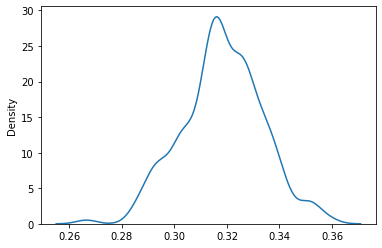

In [147]:
sns.kdeplot(positions[len(positions)//2:]);

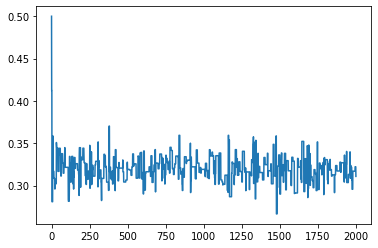

In [148]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(positions)), positions);

## 9H7

In [4]:
def u(q):
    return -np.sum(stats.bernoulli(p=q).logpmf(data))

In [5]:
u(.5)

693.1471805599454

In [6]:
def u_gradient(q):
    return -np.sum(np.where(data==1, 1/q, -(1/(1-q))))

In [7]:
np.zeros((3, 2))

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [8]:
u_gradient(.3)

-14.285714285714324

In [17]:
import dataclasses

@dataclasses.dataclass
class Q:
    q: object = None
    traj: object = None
    ptraj: object = None
    accept: object = None
    
def hmc2(u, grad_u, epsilon, l, current_q):
    q = current_q
    p = stats.norm(loc=0, scale=1).rvs(size=1)
    current_p = p
    # half step for momentum at the beginning
    p = p - epsilon*grad_u(q)/2
    # save trajectory
    qtraj = np.zeros(l+1)
    ptraj = qtraj.copy()
    qtraj[0] = current_q
    ptraj[0] = p
    
    for i in range(l):
        q = q + epsilon*p
        if q>1:
            q = 2 -q
        if q < 0:
            q = 0 - q
        if i!=(l-1):
            p = p - epsilon*grad_u(q)
            ptraj[i+1] = p
        qtraj[i+1] = q
    
    p = p - epsilon*grad_u(q)/2
    ptraj[l] = p
    p = -p
    current_u = u(current_q)
    current_k = np.sum(current_p**2)/2
    proposed_u = u(q)
    proposed_k = np.sum(p**2)/2
    accept = 0
    if stats.uniform(loc=0, scale=1).rvs(size=1) < np.exp(current_u - proposed_u+current_k-proposed_k):
        new_q = q
        accept = 1
    else:
        new_q = current_q
    return Q(
        q=new_q,
        traj=qtraj,
        ptraj=ptraj,
        accept=accept,
    )

In [24]:

l = 28
q = Q()
step= .003
path = np.zeros(1000)
path[0] = .5
for i in range(1, 1000):
    q = hmc2(u, u_gradient, step, l, path[i-1])
    path[i] = q.q

In [25]:
q

Q(q=array([0.30005579]), traj=array([0.29583375, 0.29452504, 0.29358341, 0.29305044, 0.29294969,
       0.29328563, 0.2940434 , 0.29518948, 0.29667344, 0.29843028,
       0.30038355, 0.30244888, 0.30453772, 0.30656121, 0.30843393,
       0.31007738, 0.31142308, 0.31241526, 0.31301297, 0.31319161,
       0.31294382, 0.3122798 , 0.31122689, 0.30982857, 0.30814286,
       0.30624003, 0.30419995, 0.30210885, 0.30005579]), ptraj=array([-0.43623848, -0.31387403, -0.17765985, -0.03358289,  0.11198229,
        0.25258738,  0.38202939,  0.49465256,  0.58561312,  0.65109137,
        0.6884419 ,  0.6962787 ,  0.67449745,  0.62424082,  0.5478151 ,
        0.44856679,  0.33072787,  0.19923714,  0.05954455, -0.08259605,
       -0.22134055, -0.3509701 , -0.46610405, -0.56190566, -0.63427542,
       -0.68002626, -0.69703379, -0.68435374, -0.66332589]), accept=1)

<AxesSubplot:ylabel='Density'>

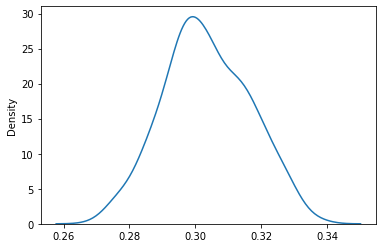

In [26]:
sns.kdeplot(path[len(path)//2:])

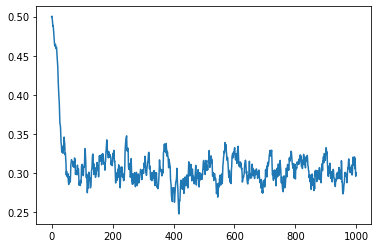

In [27]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(path)), path);